In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from scipy.spatial import Delaunay

from src.depth import DepthPoset
from src.density import SquareDensity

# SquareDensity

## Density  Functions and their Integrals

In [3]:
dens0 = SquareDensity.from_rectangles([0.2, 0.5, 0.7, 0.6], [0.3, 0.6, 0.9, 0.9], [0.4, 0.7, 0.7, 0.3], [0.5, 0.8, 0.9, 0.5])
dens1 = SquareDensity.from_rectangles([0.1], [0.8], [0.2], [0.8])

dens2 = dens0 + dens1
dens3 = abs(dens0 - dens1)

denses = [dens0, dens1, dens2, dens3]
dens_labels = ['dens0', 'dens1', 'dens0 + dens1', '|dens0 - dens1|']

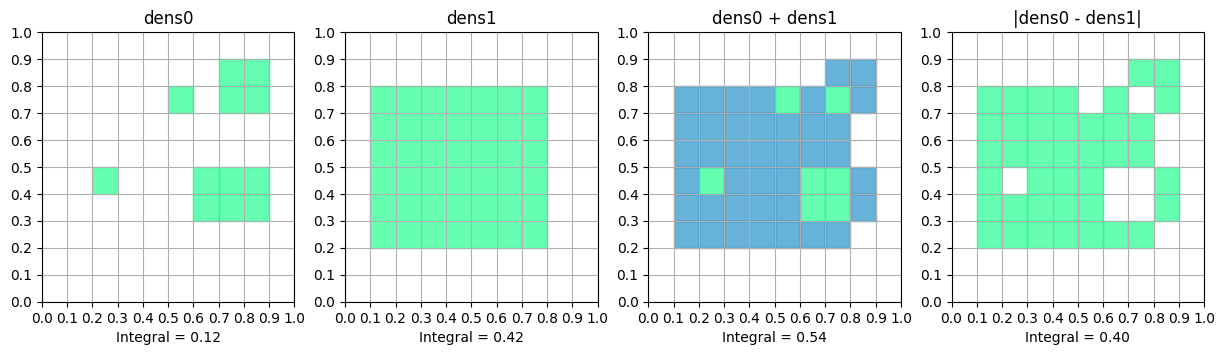

In [4]:
fig, axs = plt.subplots(1, len(denses))
fig.set_figheight(3.5)
fig.set_figwidth(15)

for i, dens in enumerate(denses):
    axs[i].set_title(dens_labels[i])
    dens.show(cmap='winter', alpha=0.6, ax=axs[i])
    
    axs[i].set_xticks(np.linspace(0, 1, 11))
    axs[i].set_yticks(np.linspace(0, 1, 11))
    axs[i].grid(True)
    
    axs[i].text(0.5, -0.15, f"Integral = {dens.integral():.2f}", ha='center', transform=axs[i].transAxes)
        
plt.show(fig)

# Density (proximity) Functions of Depth Posets and the Distance

## Simplicial complex

In [5]:
points = np.random.random([18, 2])
triangles = Delaunay(points)

filtrations = list(np.random.random(size=[2, triangles.nsimplex]))
for i in range(1):
    filtrations.append(filtrations[1] + 0.1*(np.random.random(size=filtrations[1].shape) - 0.5))

strees = []
for filtration in filtrations:
    stree = gh.SimplexTree()
    for simplex, filtration_value in zip(triangles.simplices, filtration):
        stree.insert(simplex, filtration_value)
    strees.append(stree)

depth_posets = [DepthPoset.from_simplex_tree(stree) for stree in strees]

denses = [SquareDensity.from_depth_poset(dp) for dp in depth_posets]

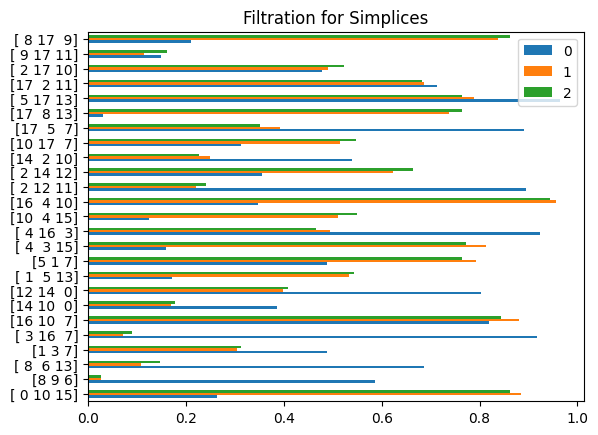

In [6]:
pd.DataFrame(filtrations, columns=[str(i) for i in triangles.simplices]).transpose().plot(kind='barh')
plt.title('Filtration for Simplices')
plt.show()

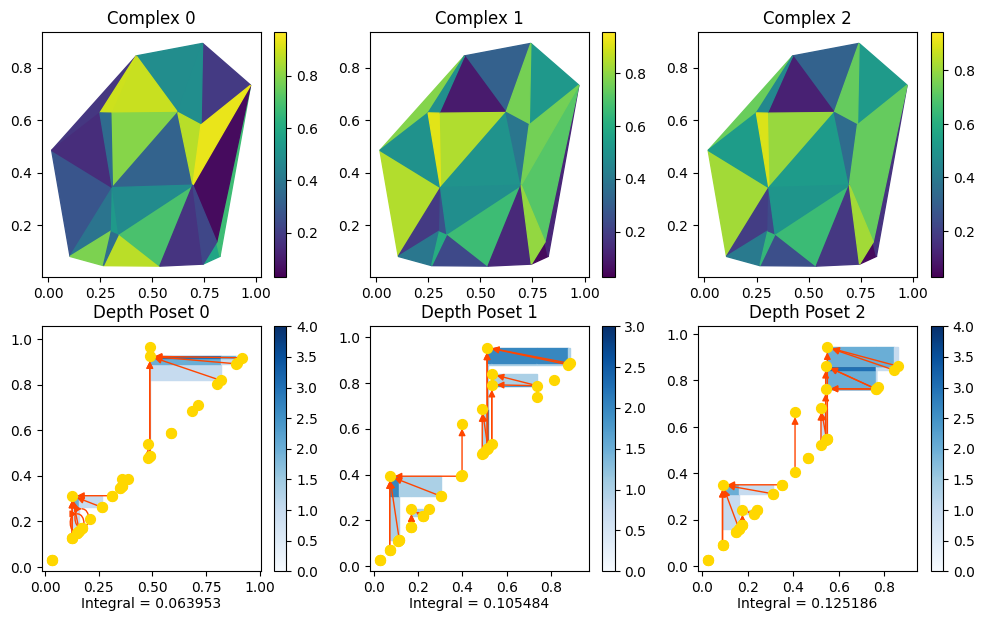

In [7]:
fig, axs = plt.subplots(2, len(filtrations))
fig.set_figheight(7)
fig.set_figwidth(12)

# Draw simplices and their filtration
cmap = plt.get_cmap('viridis')
for i, filtration in enumerate(filtrations):
    axs[0, i].set_title(f'Complex {i}')
    for filter_value, simplex in zip(filtration, triangles.simplices):
        x, y = points[simplex].transpose()
        axs[0, i].fill(x, y, color=cmap(filter_value))
    norm = Normalize(vmin=np.min(filtration), vmax=np.max(filtration))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[0, i])

for i, (dp, dens) in enumerate(zip(depth_posets, denses)):
    axs[1, i].set_title(f'Depth Poset {i}')
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[1, i], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    axs[1, i].text(0.5, -0.15, f"Integral = {dens.integral():.6f}", ha='center', transform=axs[1, i].transAxes)
    
    sm = dens.show(cmap='Blues', alpha=1, ax=axs[1, i], zorder=0)
    cbar = plt.colorbar(sm, ax=axs[1, i])
    

In [8]:
def density_distance(dp0: DepthPoset, dp1: DepthPoset, p: float=1) -> float:
    """
    """
    return (abs(SquareDensity.from_depth_poset(dp0) - SquareDensity.from_depth_poset(dp1))**p).integral()**(1/p)

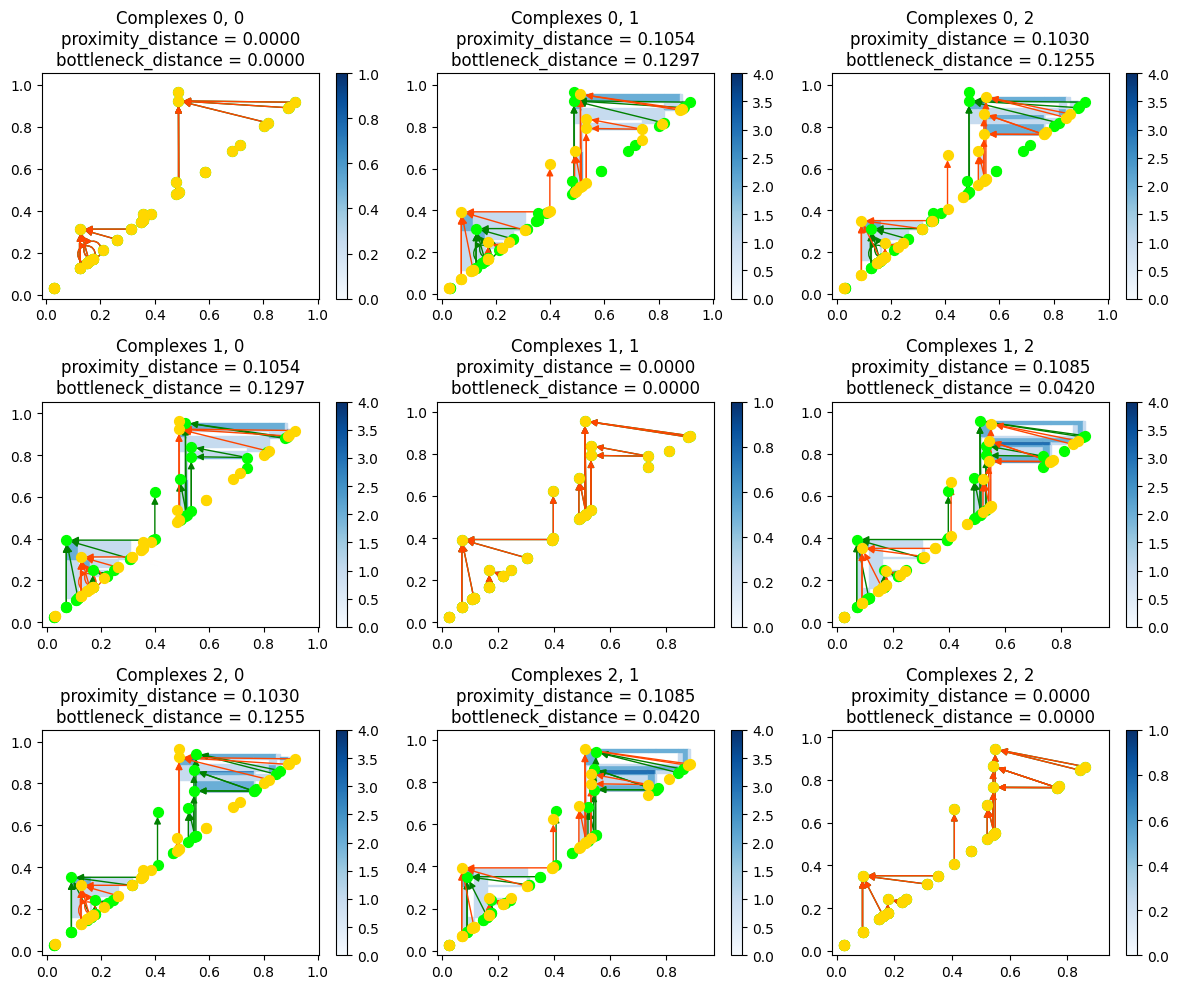

In [9]:
fig, axs = plt.subplots(len(depth_posets), len(depth_posets))
fig.set_figheight(10)
fig.set_figwidth(12)

for i, j in itertools.product(np.arange(len(depth_posets)), repeat=2):
    dp0, dp1 = depth_posets[i], depth_posets[j]
    stree0, stree1 = strees[i], strees[j]
    diag0, diag1 = stree0.persistence(), stree1.persistence()
    diag0 = [i[1] for i in diag0]
    diag1 = [i[1] for i in diag1]
    
    nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.persistant_layout(), ax=axs[i, j], 
                     node_size=50, node_color='lime', edge_color='green', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.persistant_layout(), ax=axs[i, j], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    dens = abs(denses[i] - denses[j])
    
    sm = dens.show(cmap='Blues', alpha=1, ax=axs[i, j], zorder=0)
    cbar = plt.colorbar(sm, ax=axs[i, j])
    
    annotation = f"Complexes {i}, {j}\n"
    annotation += f"proximity_distance = {density_distance(dp0, dp1):.4f}\n"
    annotation += f"bottleneck_distance = {gh.bottleneck_distance(diag0, diag1):.4f}"
    axs[i, j].set_title(annotation)
plt.tight_layout()

## Michals case

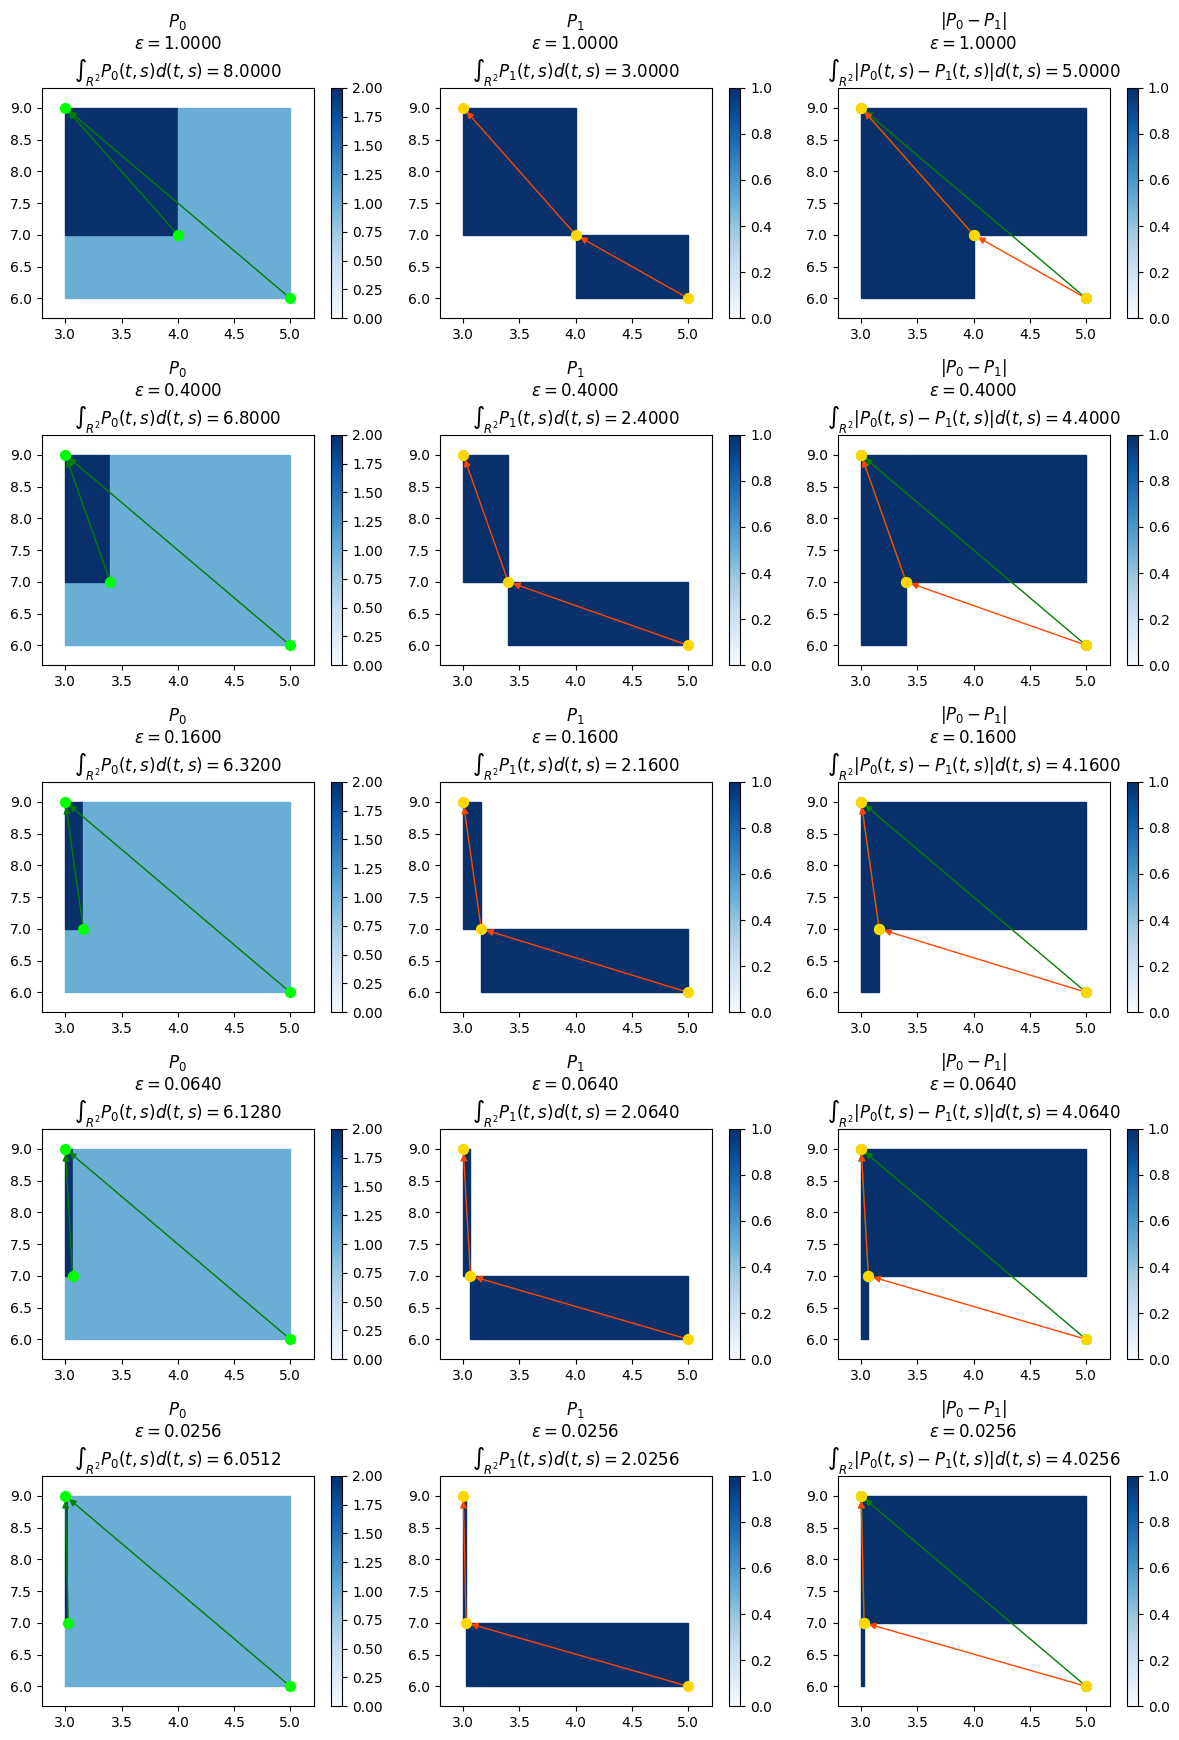

In [10]:
eps_values = 0.4**np.arange(5)


fig, axs = plt.subplots(len(eps_values), 3)
fig.set_figheight(3.5*len(eps_values))
fig.set_figwidth(12)

for i_eps, eps in enumerate(eps_values):
    
    filtration0 = {(0,): 1, 
                   (1,): 3, 
                   (2,): 3 + eps, 
                   (3,): 5, 
                   (0, 1): 9, 
                   (2, 1): 7, 
                   (3, 1): 6}
    filtration1 = {(0,): 1, 
                   (1,): 3 + eps, 
                   (2,): 3, 
                   (3,): 5, 
                   (0, 1): 9, 
                   (2, 1): 7, 
                   (3, 1): 6}
    
    stree0 = gh.SimplexTree()
    for key, value in filtration0.items():
        stree0.insert(key, filtration=value)
    stree1 = gh.SimplexTree()
    for key, value in filtration1.items():
        stree1.insert(key, filtration=value)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)
    
    dens0 = SquareDensity.from_depth_poset(dp0)
    dens1 = SquareDensity.from_depth_poset(dp1)
    dens2 = abs(dens0 - dens1)

    sm0 = dens0.show(ax=axs[i_eps, 0])
    sm1 = dens1.show(ax=axs[i_eps, 1])
    sm2 = dens2.show(ax=axs[i_eps, 2])

    nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.persistant_layout(), ax=axs[i_eps, 0], 
                     node_size=50, node_color='lime', edge_color='green', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.persistant_layout(), ax=axs[i_eps, 1], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.persistant_layout(), ax=axs[i_eps, 2], 
                     node_size=50, node_color='lime', edge_color='green', with_labels=False, hide_ticks=False)
    nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.persistant_layout(), ax=axs[i_eps, 2], 
                     node_size=50, node_color='gold', edge_color='orangered', with_labels=False, hide_ticks=False)
    
    plt.colorbar(sm0, ax=axs[i_eps, 0])
    plt.colorbar(sm1, ax=axs[i_eps, 1])
    plt.colorbar(sm2, ax=axs[i_eps, 2])

    axs[i_eps, 0].set_title(f'$P_0$\n$\\epsilon={eps:.4f}$\n$\\int_{{R^2}} P_0(t, s) d(t, s) = {dens0.integral():.4f}$')
    axs[i_eps, 1].set_title(f'$P_1$\n$\\epsilon={eps:.4f}$\n$\\int_{{R^2}} P_1(t, s) d(t, s) = {dens1.integral():.4f}$')
    axs[i_eps, 2].set_title(f'$|P_0 - P_1|$\n$\\epsilon={eps:.4f}$\n$\\int_{{R^2}} |P_0(t, s) - P_1(t, s)|d(t, s) = {dens2.integral():.4f}$')
plt.tight_layout()

plt.show()

__Conclusion:__ The transposition can change not only 4 simplices in transposed pairs, and the distance does not catch this situations and this is not stable.